# LabelMe Dataset

* Input patterns: $256\times256$ real RGB images of landscapes.
* Labels: Mutually exclusive types of landscape.
    * Classes: *highway, insidecity, tallbuilding, street, forest, coast, mountain, opencountry*
* Ground truth: The original/real image landscape.
* Annotations: re-collected from Amazon Mechanical Turk (AMT).
    * Number of annotators (T) = 59  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    
np.set_printoptions(precision=4, suppress=True)

2024-01-14 20:07:48.976173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 20:07:49.715322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./data/LabelMe/"

### Load Data and preprocess

In [4]:
Xstd_train = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

Xstd_val = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

Xstd_test = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",Xstd_train.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


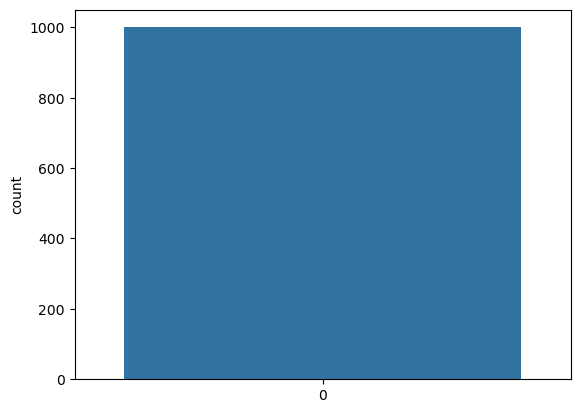

In [5]:
sns.countplot(Z_train)
plt.show()

### Load annotations 

In [6]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1

N,T = y_obs.shape
print("Shape (data,annotators): ",(N,T))
print("Classes: ",np.max(y_obs)+1)

Loading AMT data...
Shape (data,annotators):  (1000, 59)
Classes:  8


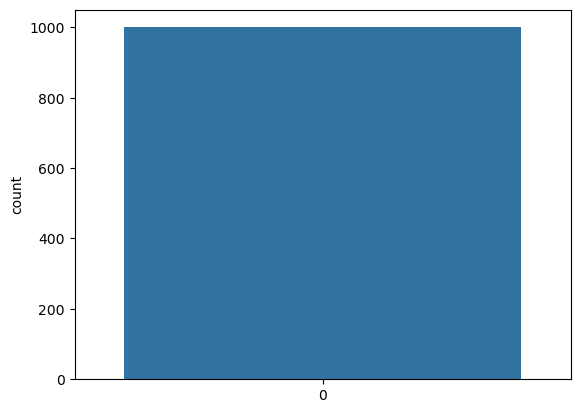

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


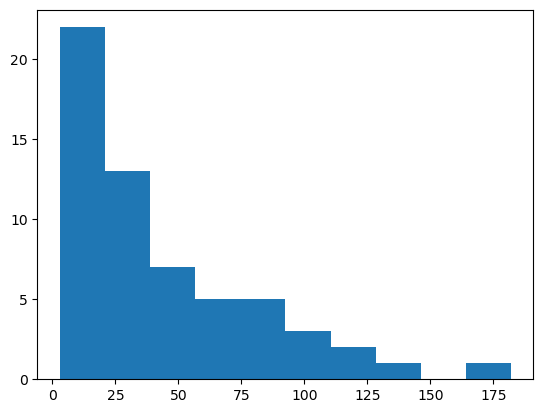

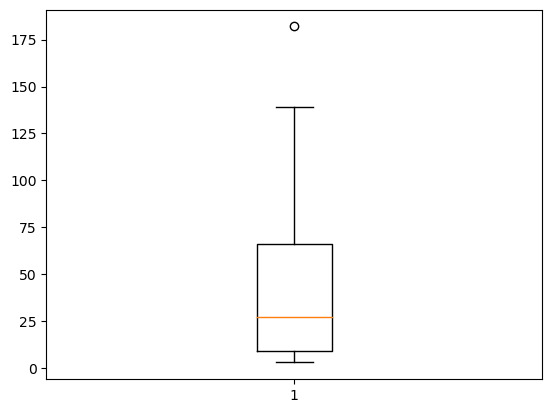

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182
Mean annotations by an annotator:  43.16949152542373


In [7]:
N_ann = np.sum(y_obs != -1,axis=1) 

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

T_weights = np.sum(y_obs != -1,axis=0) #number of annotations per annotator
print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Upper Bound Model -- ideal

In [8]:
#### Delta Convergence criteria
from codeE.learning_models import MLP_Keras, Clonable_Model
from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

NO TABULATE INSTALLED!


In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
clone_UB = Clonable_Model(model_UB, model_UB.input)
print("Trained Ideal Model, Epochs to converge =",len(hist.epoch))

2024-01-14 20:07:52.762940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 20:07:52.802410: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Trained Ideal Model, Epochs to converge = 10


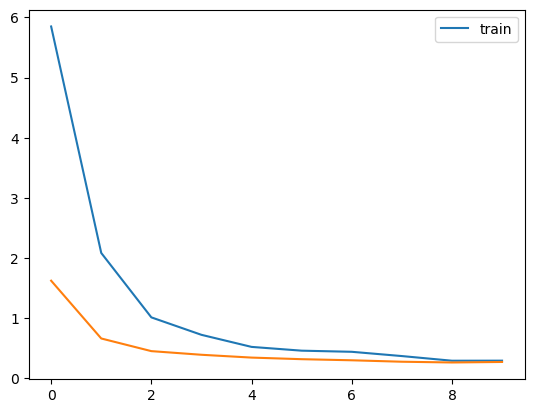

In [10]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [11]:
from codeE.evaluation import f1score_model
print("Train accuracy of model =", f1score_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", f1score_model(model_UB, Xstd_test, Z_test))

32/32 [==============================] - 0s 966us/step
Train accuracy of model = 0.9630492991955397
38/38 [==============================] - 0s 1ms/step
Test accuracy of model = 0.9214300697876983


### Generate Matrix representation of both scenarios

In [12]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape (N,T,K)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape (N,T,K)=  (1000, 59, 8)
Global representation shape (N,K)=  (1000, 8)


### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [13]:
from codeE.utils import generate_Individual_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)
conf_matrix_I

Individual matrix shape (T,K,K)=  (59, 8, 8)


array([[[0.7778, 0.1111, 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.7857, 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.2308, 0.7692, ..., 0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 1.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.0556, 0.2222, 0.5556]],

       [[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.125 , 0.125 , 0.125 , ..., 0.125 , 0.125 , 0.125 ],
        ...,
        [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.5   , 0.5   ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.5   , 0.5   ]],

       [[0.375 , 0.125 , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.75  , 0.25  , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0. 

Global matrix shape (K,K)=  (8, 8)


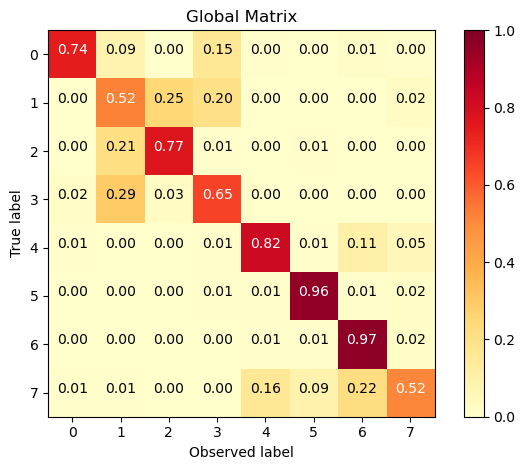

In [14]:
from codeE.utils import generate_Global_conf

#confe_matrix_G = generate_Global_conf(Z_train, y_obs_categorical)
confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(confe_matrix_G, np.arange(8), title= "Global Matrix")

## Aggregation methods (without predictive model)
* Majority Voting (MV)
* Weighted Majority Voting
* Dawid and Skene (DS): with inference

In [15]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="global")

mv_soft = label_A.infer(  r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')
mv_hard

array([1, 2, 1, 4, 5, 2, 0, 4, 2, 5, 0, 1, 2, 3, 1, 3, 6, 4, 7, 4, 1, 1,
       2, 1, 3, 6, 0, 4, 6, 2, 4, 3, 6, 6, 5, 7, 4, 0, 5, 4, 5, 5, 2, 0,
       4, 2, 1, 5, 1, 6, 1, 7, 1, 0, 1, 6, 6, 7, 4, 4, 2, 3, 0, 5, 1, 1,
       4, 5, 2, 6, 4, 1, 7, 6, 6, 1, 5, 6, 6, 4, 1, 3, 6, 5, 4, 5, 6, 4,
       0, 4, 7, 0, 3, 3, 5, 5, 7, 4, 1, 3, 5, 4, 4, 1, 7, 7, 6, 2, 4, 2,
       2, 1, 7, 4, 0, 7, 7, 4, 0, 1, 6, 4, 7, 7, 2, 2, 2, 4, 1, 3, 1, 6,
       0, 6, 6, 1, 6, 0, 4, 6, 0, 3, 0, 5, 7, 0, 4, 3, 2, 3, 4, 0, 5, 6,
       4, 3, 0, 6, 1, 7, 3, 1, 7, 2, 1, 7, 0, 3, 5, 5, 1, 0, 5, 2, 6, 2,
       5, 4, 2, 5, 5, 2, 5, 4, 3, 3, 6, 4, 0, 1, 0, 4, 7, 2, 5, 0, 7, 4,
       1, 0, 0, 5, 0, 3, 6, 4, 1, 7, 1, 1, 1, 4, 6, 5, 5, 4, 1, 6, 1, 2,
       1, 5, 5, 4, 4, 7, 2, 0, 2, 0, 1, 5, 2, 4, 3, 5, 6, 6, 1, 1, 4, 1,
       6, 4, 2, 6, 2, 7, 5, 4, 3, 4, 2, 7, 6, 4, 2, 1, 5, 7, 3, 3, 5, 6,
       1, 6, 6, 1, 7, 3, 5, 2, 6, 5, 1, 1, 6, 1, 1, 5, 1, 4, 4, 1, 5, 3,
       6, 2, 6, 4, 3, 6, 1, 4, 1, 3, 6, 0, 2, 6, 0,

In [16]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

mv_soft = label_A.infer(  y_obs_categorical, 'softMV')
mv_hard = label_A.predict(y_obs_categorical, 'hardMV')
mv_soft

array([[0.    , 0.6667, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.6667, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.3333, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.3333, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [17]:
print("ACC MV on train:",np.mean(mv_hard==Z_train))

ACC MV on train: 0.769


### generate confusion matrix on MV

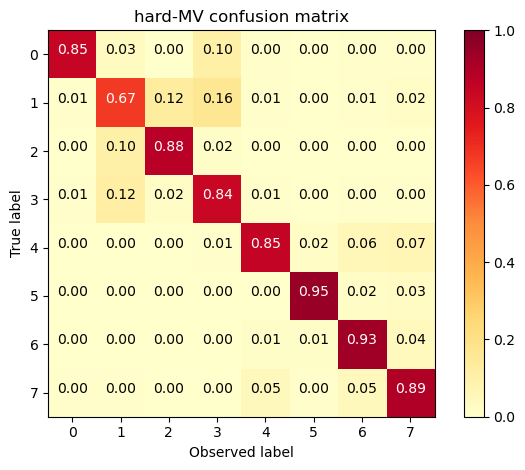

In [18]:
from codeE.utils import generate_confusionM
prob_Yz = generate_confusionM(mv_hard, r_obs) #confusion matrix of all annotators
plot_confusion_matrix(prob_Yz, np.arange(8), title= "hard-MV confusion matrix")

### Metrics to compare the estimation of confusion matrix

/home/panshop/Documents/PhD/PyLearningCrowds/codeE/utils.py:160: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


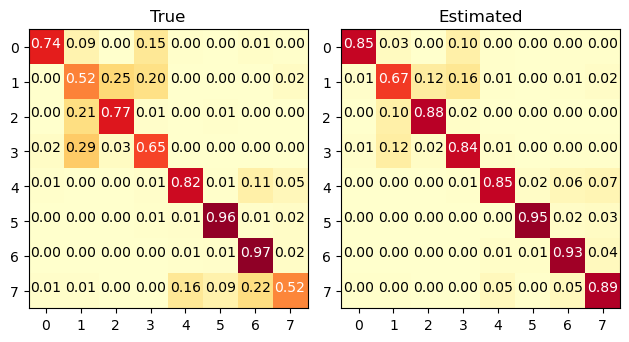

In [19]:
from codeE.utils import compare_conf_ma
compare_conf_ma(prob_Yz, true_conf_mat=confe_matrix_G, text=True)

In [20]:
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.03469416227325334
Global D (based on normalized Frobenius) = 0.07360906898975372


##### Weighted

In [21]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

Wmv_soft = label_A.infer(y_obs_categorical, 'softMV', weights=T_weights)
Wmv_soft

array([[0.    , 0.3309, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3374, 0.6626, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.306 , 0.1913, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.0848, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [22]:
print("ACC MV on train:",np.mean(Wmv_soft.argmax(axis=-1)==Z_train))

ACC MV on train: 0.762


### Dawid and Skene model

In [23]:
from codeE.methods import LabelInf_EM as DS

DS_model = DS(init_Z='softmv') 
#DS_model = DS(init_Z='softmv', priors="None", fast=False) 
    
# if you want you can initialize step E forcing some method
#DS_model.init_E(y_obs_categorical)
#DS_model.get_qestimation()

hist = DS_model.fit(y_obs_categorical, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Z marginal shape (8,)
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2837.160	
Iter 2/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2760.562	Tol1: 0.02700	Tol2: 0.25264	
Iter 3/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2734.589	Tol1: 0.00941	Tol2: 0.10178	
Iter 4/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2723.378	Tol1: 0.00410	Tol2: 0.08455	
Iter 5/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2717.710	Tol1: 0.00208	Tol2: 0.14913	
Iter 6/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -2714.123	Tol1: 0.00132	Tol2: 0.30754	
Iter 7/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2712.104	Tol1: 0.00074	Tol2: 0.13994	
Iter 8/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -2710.701	Tol1: 0.00052	Tol2: 0.05798	
Iter 9/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2709.480	Tol1: 0.00045	Tol2: 0.04514	
Iter 10/50 

In [24]:
print("p(z) = ",DS_model.get_marginalZ())

ds_labels = DS_model.infer() #could infer/predict on the trainint set only
ds_labels

p(z) =  [0.0766 0.1127 0.1443 0.1139 0.1431 0.1434 0.1716 0.0944]


array([[0.    , 0.0633, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.1574, 0.8426, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.999 , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.0345, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0022, 0.9978, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [25]:
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC D&S on train: 0.804


### Global Label Noise - Without predictive model

In [26]:
from codeE.methods import LabelInf_EM_G as LabG_Noise

LabG_Noise_model = LabG_Noise(init_Z='softmv') 
LabG_Noise_model.fit(r_obs, max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Beta:  (8, 8)
Q estimate:  (1000, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3285.009	
Iter 2/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3272.315	Tol1: 0.00386	Tol2: 0.22739	
Iter 3/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3269.516	Tol1: 0.00086	Tol2: 0.14194	
Iter 4/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3268.494	Tol1: 0.00031	Tol2: 0.11849	
Iter 5/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3268.016	Tol1: 0.00015	Tol2: 0.09671	
Iter 6/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3267.756	Tol1: 0.00008	Tol2: 0.07336	
Iter 7/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3267.597	Tol1: 0.00005	Tol2: 0.05640	
Iter 8/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3267.492	Tol1: 0.00003	Tol2: 0.04348	
Iter 9/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -3267.418	Tol1: 0.00002	Tol2: 0.04091	
Iter 10/50
M step: done,  E step: done //  (in 0.00 sec)	lo

array([-3285.0093, -3272.3149, -3269.5156, -3268.4939, -3268.0161,
       -3267.7559, -3267.5974, -3267.4922, -3267.4177, -3267.3618,
       -3267.3186, -3267.2847, -3267.2578, -3267.2368, -3267.2188,
       -3267.2051])

In [27]:
print("p(z) = ", LabG_Noise_model.get_marginalZ())

LabG_labels = LabG_Noise_model.infer() 
LabG_labels

p(z) =  [0.0764 0.1243 0.1405 0.107  0.1456 0.1432 0.1733 0.0896]


array([[0.0003, 0.7381, 0.0008, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0516, 0.9468, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.7364, 0.0197, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.0013, 0.2212, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0021, 0.9979, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0014, 0.    , ..., 0.001 , 0.0026, 0.9853]],
      dtype=float32)

In [28]:
print("ACC on train:",np.mean(LabG_labels.argmax(axis=1)==Z_train))


ACC on train: 0.787


### Second Phase
train a predictive model over the inference/aggregation label

In [29]:
from codeE.evaluation import accuracy_model

In [30]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvsoft, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvsoft, Xstd_test, Z_test))

Trained model over soft-MV, Epochs to converge = 9
32/32 [==============================] - 0s 1ms/step
Train accuracy of model = 0.832
38/38 [==============================] - 0s 5ms/step
Test accuracy of model = 0.8131313131313131


In [31]:
mv_hard_onehot = keras.utils.to_categorical(mv_hard)
mv_hard_onehot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [32]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvhard, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvhard, Xstd_test, Z_test))

Trained model over hard-MV, Epochs to converge = 9
32/32 [==============================] - 0s 1ms/step
Train accuracy of model = 0.813
38/38 [==============================] - 0s 2ms/step
Test accuracy of model = 0.803030303030303


In [33]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_ds, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_ds, Xstd_test, Z_test))

Trained model over D&S, Epochs to converge = 10
32/32 [==============================] - 0s 1ms/step
Train accuracy of model = 0.859
38/38 [==============================] - 0s 1ms/step
Test accuracy of model = 0.82996632996633


In [34]:
model_lg = clone_UB.get_model()
model_lg.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_lg.fit(Xstd_train, LabG_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over Global LabelNoise, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_lg, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_lg, Xstd_test, Z_test))

Trained model over Global LabelNoise, Epochs to converge = 9
32/32 [==============================] - 0s 2ms/step
Train accuracy of model = 0.835
38/38 [==============================] - 0s 1ms/step
Test accuracy of model = 0.8080808080808081


## Raykar Model (joint predict model)

In [18]:
model_R = clone_UB.get_model()
model_R.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
Total params: 66696 (260.53 KB)
Trainable params: 66696 (260.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
from codeE.methods import ModelInf_EM as Raykar
R_model = Raykar(init_Z="softmv")
#R_model = Raykar(init_Z="model", priors='laplace', n_init_Z=5)

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
R_model.set_model(model_R, **args)

# if you want you can initialize step E forcing some method
#R_model.init_E(y_obs_categorical, method="hardmv")
#R_model.get_qestimation()

2024-01-14 19:57:13.110632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 19:57:13.111295: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
#logL_hists,i_r = R_model.multiples_run(20, Xstd_train,y_obs_categorical,
#                                        max_iter=EPOCHS_BASE, tolerance=TOL)

R_model.fit(Xstd_train, y_obs_categorical, runs=20, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.53 sec)	logL: -1894.837	
Iter 2/50 
4/4 [==============================] - 0s 4ms/step
 done //  (in 0.17 sec)	logL: -1320.979	Tol1: 0.30285	Tol2: 2.47678	
Iter 3/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.19 sec)	logL: -1182.768	Tol1: 0.10463	Tol2: 0.17736	
Iter 4/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.16 sec)	logL: -1118.281	Tol1: 0.05452	Tol2: 0.89757	
Iter 5/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.14 sec)	logL: -1085.091	Tol1: 0.02968	Tol2: 9.96920	
Iter 6/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.16 sec)	logL: -1052.337	Tol1: 0.03018	Tol2: 2.23141	
Iter 7/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -1025.843	Tol1: 0.02518	Tol2: 0.12687	
Iter 8/50 
4/4 [==================

4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -1003.227	Tol1: 0.02480	Tol2: 0.05700	
Iter 9/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -984.458	Tol1: 0.01871	Tol2: 0.03260	
Iter 10/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -969.369	Tol1: 0.01533	Tol2: 2.96807	
Iter 11/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -955.020	Tol1: 0.01480	Tol2: 0.18128	
Iter 12/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -945.168	Tol1: 0.01032	Tol2: 0.04207	
Iter 13/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.13 sec)	logL: -933.589	Tol1: 0.01225	Tol2: 0.05922	
Iter 14/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.15 sec)	logL: -921.952	Tol1: 0.01247	Tol2: 0.02412	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)


4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -1023.873	Tol1: 0.04068	Tol2: 1.23665	
Iter 7/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -997.402	Tol1: 0.02585	Tol2: 0.59493	
Iter 8/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.13 sec)	logL: -971.438	Tol1: 0.02603	Tol2: 0.10904	
Iter 9/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -952.790	Tol1: 0.01920	Tol2: 0.04421	
Iter 10/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.15 sec)	logL: -938.067	Tol1: 0.01545	Tol2: 0.03975	
Iter 11/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.18 sec)	logL: -928.650	Tol1: 0.01004	Tol2: 0.03533	
Iter 12/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.16 sec)	logL: -914.859	Tol1: 0.01485	Tol2: 0.27055	
Iter 13/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -905

4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -1359.545	Tol1: 0.28488	Tol2: 0.32054	
Iter 3/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -1224.230	Tol1: 0.09953	Tol2: 1.50650	
Iter 4/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -1146.688	Tol1: 0.06334	Tol2: 0.15634	
Iter 5/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -1095.688	Tol1: 0.04448	Tol2: 3.62885	
Iter 6/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -1059.740	Tol1: 0.03281	Tol2: 1.71169	
Iter 7/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -1029.208	Tol1: 0.02881	Tol2: 0.14579	
Iter 8/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -1001.652	Tol1: 0.02677	Tol2: 0.07909	
Iter 9/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.11 sec)	logL: -9

4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -1197.986	Tol1: 0.11159	Tol2: 5.63700	
Iter 4/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -1139.625	Tol1: 0.04872	Tol2: 0.91274	
Iter 5/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -1087.186	Tol1: 0.04601	Tol2: 0.71386	
Iter 6/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.13 sec)	logL: -1050.313	Tol1: 0.03392	Tol2: 4.74377	
Iter 7/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -1028.364	Tol1: 0.02090	Tol2: 0.47442	
Iter 8/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -1008.879	Tol1: 0.01895	Tol2: 0.44305	
Iter 9/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.17 sec)	logL: -985.686	Tol1: 0.02299	Tol2: 0.05892	
Iter 10/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -9

([[-1894.837158203125,
   -1320.9794921875,
   -1182.767822265625,
   -1118.280517578125,
   -1085.090576171875,
   -1052.337158203125,
   -1025.843017578125,
   -1002.4627075195312,
   -983.817138671875,
   -969.8848876953125,
   -954.39013671875],
  [-2080.670654296875,
   -1386.086669921875,
   -1223.5743408203125,
   -1154.651123046875,
   -1106.661865234375,
   -1068.321044921875,
   -1041.76171875,
   -1019.30078125,
   -997.4388427734375,
   -974.7938232421875,
   -958.91015625,
   -944.339111328125,
   -930.2013549804688,
   -917.255859375],
  [-1927.7314453125,
   -1323.7557373046875,
   -1168.4954833984375,
   -1112.668701171875,
   -1074.427490234375,
   -1040.551513671875,
   -1015.7670288085938,
   -990.87255859375,
   -967.7081298828125,
   -948.0,
   -932.4144897460938,
   -921.4137573242188,
   -908.3211669921875,
   -896.2547607421875],
  [-1851.552001953125,
   -1258.572265625,
   -1133.345947265625,
   -1084.393798828125,
   -1054.208251953125,
   -1025.362060546875,

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [22]:
raykar_fx = R_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, Xstd_test, Z_test))

32/32 [==============================] - 0s 1ms/step
Train accuracy of model = 0.87
38/38 [==============================] - 0s 1ms/step
Test accuracy of model = 0.8611111111111112


## Reliability Annotator Model 

In [23]:
aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
Total params: 66696 (260.53 KB)
Trainable params: 66696 (260.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from codeE.methods import ModelInf_EM_R
LogReg_crowds = ModelInf_EM_R()

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
LogReg_crowds.set_model(aux_model, **args)

#LogReg_crowds.init_E(Xstd_train, y_obs_categorical, method="softmv")
#LogReg_crowds.get_restimation()

logL_hists,i_r = LogReg_crowds.fit(Xstd_train, y_obs_categorical, runs = 20, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
b shape:  (59, 1)
R estimate shape:  (1000, 59, 1)
Iter 1/50 
M step:

2024-01-14 19:58:53.096980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 19:58:53.097504: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 2ms/step
 done //  (in 0.49 sec)	logL: -4334.403	
Iter 2/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3518.722	Tol1: 0.18819	Tol2: 0.08260	
Iter 3/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3455.270	Tol1: 0.01803	Tol2: 0.13387	
Iter 4/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3462.596	Tol1: 0.00212	Tol2: 0.14025	
Iter 5/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3499.225	Tol1: 0.01058	Tol2: 0.10233	
Iter 6/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3556.227	Tol1: 0.01629	Tol2: 0.08315	
Iter 7/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.17 sec)	logL: -3607.149	Tol1: 0.01432	Tol2: 0.06515	
Iter 8/50 
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.13 sec)	logL: -3657.148	Tol1: 0.01386	Tol2: 

4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3557.370	Tol1: 0.01479	Tol2: 0.04962	
Iter 10/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3583.643	Tol1: 0.00739	Tol2: 0.03503	
Iter 11/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3566.397	Tol1: 0.00481	Tol2: 0.02113	
Finished training
Initializing new EM...
b shape:  (59, 1)
R estimate shape:  (1000, 59, 1)
Iter 1/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.57 sec)	logL: -6163.295	
Iter 2/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -4083.240	Tol1: 0.33749	Tol2: 0.16393	
Iter 3/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3609.263	Tol1: 0.11608	Tol2: 0.20203	
Iter 4/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3553.773	Tol1: 0.01537	Tol2: 0.10176	
Iter 5/50 
4/4 [============

 done //  (in 0.13 sec)	logL: -3422.040	Tol1: 0.01007	Tol2: 0.07780	
Iter 6/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3450.558	Tol1: 0.00833	Tol2: 0.05528	
Iter 7/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3556.776	Tol1: 0.03078	Tol2: 0.04038	
Iter 8/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3633.549	Tol1: 0.02159	Tol2: 0.05035	
Iter 9/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3686.042	Tol1: 0.01445	Tol2: 0.05424	
Iter 10/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3719.610	Tol1: 0.00911	Tol2: 0.04013	
Iter 11/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.12 sec)	logL: -3785.449	Tol1: 0.01770	Tol2: 0.03049	
Iter 12/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3845.179	Tol1: 0.01578	Tol2: 0.05959	
Iter 13/50 

4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3419.542	Tol1: 0.09251	Tol2: 0.06547	
Iter 8/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3577.941	Tol1: 0.04632	Tol2: 0.08103	
Iter 9/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3646.023	Tol1: 0.01903	Tol2: 0.08054	
Iter 10/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3686.877	Tol1: 0.01121	Tol2: 0.04930	
Iter 11/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.13 sec)	logL: -3699.374	Tol1: 0.00339	Tol2: 0.02784	
Finished training
Initializing new EM...
b shape:  (59, 1)
R estimate shape:  (1000, 59, 1)
Iter 1/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.49 sec)	logL: -4622.489	
Iter 2/50 
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3634.151	Tol1: 0.21381	Tol2: 0.10075	
Iter 3/50 
4/4 [============

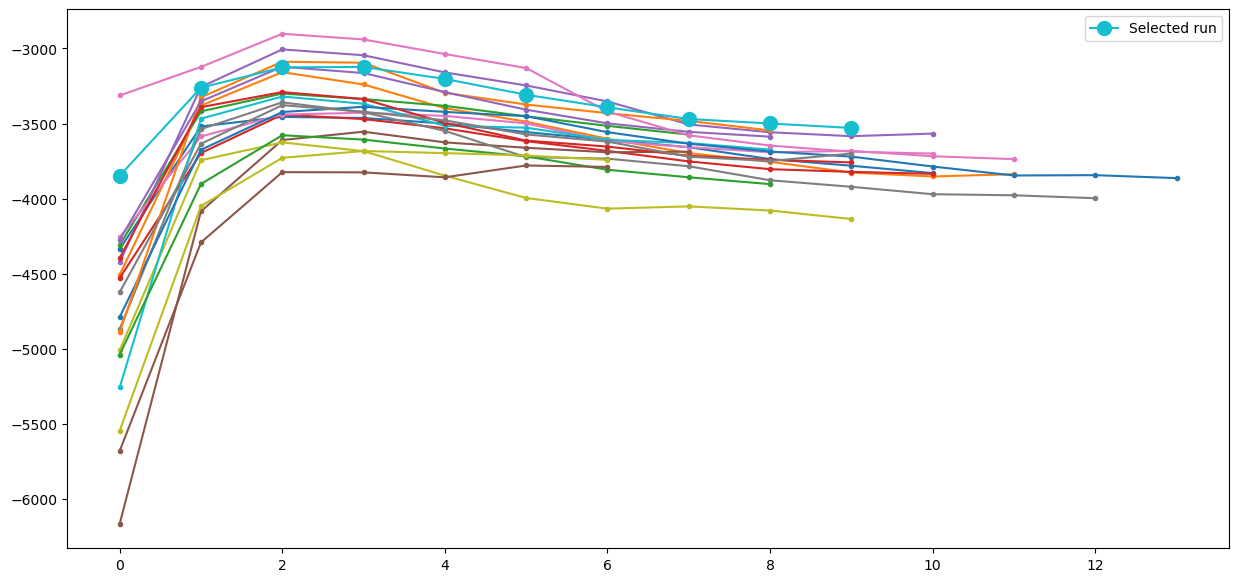

In [25]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [26]:
LogReg_fx = LogReg_crowds.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(LogReg_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(LogReg_fx, Xstd_test, Z_test))

32/32 [==============================] - 0s 2ms/step
Train accuracy of model = 0.595
38/38 [==============================] - 0s 1ms/step
Test accuracy of model = 0.6018518518518519


## C-MoA
Groups over individual scenario

#### Auxiliar representation with variable number of annotations per annotator and identity

In [15]:
y_cat_var, A_idx_var = set_representation(y_obs,"onehotvar")
print("Individual sparse representation, variable shape (N,)= ",y_cat_var.shape)
K = y_cat_var[0].shape[1]
print("one-hot vectors of K-dimensions, K=",K)
y_cat_var

Individual sparse representation, variable shape (N,)=  (1000,)
one-hot vectors of K-dimensions, K= 8


array([array([[0, 0, 0, 1, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[1, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0],
        

In [16]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
Total params: 66696 (260.53 KB)
Trainable params: 66696 (260.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Fixed annotators representation (non trainable embedding)

In [17]:
T= np.concatenate(A_idx_var).max() +1
A_rep = np.zeros((T, K))
for i in range(N):
    for l, t_idx in enumerate(A_idx_var[i]):
        obs_t = y_cat_var[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
print("shape of annotator representation (T, R_t)=", A_rep.shape)

shape of annotator representation (T, R_t)= (59, 8)


In [18]:
from keras.models import Sequential
from keras.layers import *
group_model = Sequential()
group_model.add(Embedding(T, K, input_length=1, 
                         trainable=False,weights=[A_rep]))
                         #trainable=True))
group_model.add(Reshape([K]))
group_model.add(Dense(K*M_seted, activation='relu'))
group_model.add(Dense(M_seted, activation='softmax'))
group_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 8)              472       
                                                                 
 reshape (Reshape)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 24)                216       
                                                                 
 dense_3 (Dense)             (None, 3)                 75        
                                                                 
Total params: 763 (2.98 KB)
Trainable params: 291 (1.14 KB)
Non-trainable params: 472 (1.84 KB)
_________________________________________________________________


In [19]:
from codeE.methods import ModelInf_EM_CMOA as CMOA
CMOA_model = CMOA(M=M_seted, init_Z='softmv') 
#CMOA_model = CMOA(M=M_seted, init_Z='softmv',init_G="model",n_init_G=5)
#CMOA_model = CMOA(M=M_seted, init_Z='model',n_init_Z=3)
#CMOA_model = CMOA(M=M_seted, init_Z='model',init_G="model",n_init_Z=1,n_init_G=5)  #pre train both models

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMOA_model.set_model(aux_model, ann_model=group_model, **args)
#CMOA_model.set_model(group_model) #you also can set it manually

# if you want you can initialize step E forcing some method
#CMOA_model.init_E(y_cat_var, A_idx_var, method="hardmv")
#CMOA_model.get_qestimation()

2024-01-14 20:08:17.932385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 20:08:17.933631: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-14 20:08:18.028103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

In [20]:
logL_hists,i_r = CMOA_model.fit(Xstd_train, y_cat_var, A_idx_var, runs = 20,max_iter=EPOCHS_BASE,tolerance=TOL) 

Initializing new EM...
Doing clustering...

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
1/1 [==============================] - 0s 43ms/step
 done //  (in 1.00 sec)	logL: -3755.683	
Iter 2/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.26 sec)	logL: -3320.263	Tol1: 0.11594	Tol2: 1.23829	
Iter 3/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.34 sec)	logL: -3442.909	Tol1: 0.03694	Tol2: 2.37565	
Iter 4/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.33 sec)	logL: -3458.619	Tol1: 0.00456	Tol2: 1.08267	
Iter 5/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.24 sec)	logL: -3525.896	Tol1: 0.01945	Tol2: 0.62353	
Iter 6/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.24 sec)	logL: -3584.875	Tol1: 0.01673	Tol2: 0.57502	
Iter 7/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.26 sec)	logL: -3719.669	Tol1: 0.03760	Tol2: 4.03180	
Iter 8/50
1/1 [==============================] - 0s 16ms/step

 done //  (in 0.28 sec)	logL: -3646.814	Tol1: 0.00141	Tol2: 0.03852	
Iter 46/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.27 sec)	logL: -3649.592	Tol1: 0.00076	Tol2: 0.04093	
Iter 47/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.31 sec)	logL: -3643.173	Tol1: 0.00176	Tol2: 0.03218	
Iter 48/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.28 sec)	logL: -3624.472	Tol1: 0.00513	Tol2: 0.04198	
Iter 49/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.27 sec)	logL: -3642.874	Tol1: 0.00508	Tol2: 0.10267	
Iter 50/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.26 sec)	logL: -3631.295	Tol1: 0.00318	Tol2: 0.32513	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 66ms/step
 done //  (in 1.23 sec)	logL: -2994.423	
Iter 2/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.29 sec)	logL: -2796.027	Tol1: 0.06626	Tol2: 0.60680	
Iter 3/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -3129.660	Tol1: 0.11932	Tol2: 1.31029	
Iter 4/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.27 sec)	logL: -3805.616	Tol1: 0.21598	Tol2: 27.71925	
Iter 5/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -4282.297	Tol1: 0.12526	Tol2: 8.46303	
Iter 6/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.30 sec)	logL: -4807.161	Tol1: 0.12257	Tol2: 0.80061	
Iter 7/50
1/1 [==============================] - 0s 23ms/step
 done //  (in 0.32 sec)	logL: -5118.745	Tol1: 0.06482	Tol2: 0.49245	
Iter 8/50
1/1 [==============================] - 0s 24ms/step
 done //  (in 0.33 sec)	logL: -5152.265	Tol1: 0.00655	Tol2

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 48ms/step
 done //  (in 1.25 sec)	logL: -3256.631	
Iter 2/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.29 sec)	logL: -3118.990	Tol1: 0.04227	Tol2: 2.87797	
Iter 3/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.27 sec)	logL: -3534.706	Tol1: 0.13329	Tol2: 4.38650	
Iter 4/50
1/1 [==============================] - 0s 21ms/step
 done //  (in 0.34 sec)	logL: -3875.584	Tol1: 0.09644	Tol2: 11.67224	
Iter 5/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.34 sec)	logL: -3903.007	Tol1: 0.00708	Tol2: 1.28381	
Iter 6/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.33 sec)	logL: -3808.804	Tol1: 0.02414	Tol2: 0.71351	
Iter 7/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.32 sec)	logL: -3760.900	Tol1: 0.01258	Tol2: 0.58822	
Iter 8/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.29 sec)	logL: -3732.501	Tol1: 0.00755	Tol2

1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -3746.629	Tol1: 0.00131	Tol2: 0.08650	
Iter 47/50
1/1 [==============================] - 0s 27ms/step
 done //  (in 0.28 sec)	logL: -3739.081	Tol1: 0.00201	Tol2: 0.07742	
Iter 48/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.29 sec)	logL: -3739.892	Tol1: 0.00022	Tol2: 0.06603	
Iter 49/50
1/1 [==============================] - 0s 25ms/step
 done //  (in 0.35 sec)	logL: -3737.830	Tol1: 0.00055	Tol2: 0.05610	
Iter 50/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.28 sec)	logL: -3769.389	Tol1: 0.00844	Tol2: 0.05368	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 43ms/step
 done //  (in 1.00 sec)	logL: -3940.185	
Iter 2/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.27 sec)	logL: -3656.806	Tol1: 0.07192	Tol2: 3.63109	
Iter 3/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.29 sec)	logL: -4238.851	Tol1: 0.15917	Tol2: 6.30600	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -4150.791	Tol1: 0.02077	Tol2: 5.86454	
Iter 5/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -4464.646	Tol1: 0.07561	Tol2: 0.88254	
Iter 6/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -4888.820	Tol1: 0.09501	Tol2: 0.51603	
Iter 7/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -5158.614	Tol1: 0.05519	Tol2: 0.46819	
Iter 8/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -5184.117	Tol1: 0.00494	Tol2:

1/1 [==============================] - 0s 15ms/step
 done //  (in 0.28 sec)	logL: -5150.006	Tol1: 0.00017	Tol2: 0.03157	
Iter 47/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -5149.157	Tol1: 0.00016	Tol2: 0.03109	
Iter 48/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -5148.320	Tol1: 0.00016	Tol2: 0.02999	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 56ms/step
 done //  (in 1.03 sec)	logL: -3096.881	
Iter 2/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.31 sec)	logL: -2732.901	Tol1: 0.11753	Tol2: 0.82904	
Iter 3/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.33 sec)	logL: -2723.102	Tol1: 0.00359	Tol2: 0.52730	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.33 sec)	logL: -2919.753	Tol1: 0.07222	Tol2: 1.00436	
Iter 5/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.26 sec)	logL: -3211.142	Tol1: 0.09980	Tol2: 5.76618	
Iter 6/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.26 sec)	logL: -3607.212	Tol1: 0.12334	Tol2: 2.27931	
Iter 7/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.24 sec)	logL: -3785.245	Tol1: 0.04935	Tol2: 79.67166	
Iter 8/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -3730.211	Tol1: 0.01454	Tol2

1/1 [==============================] - 0s 18ms/step
 done //  (in 0.26 sec)	logL: -3661.621	Tol1: 0.00156	Tol2: 0.03468	
Iter 47/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.26 sec)	logL: -3658.258	Tol1: 0.00092	Tol2: 0.04298	
Iter 48/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.27 sec)	logL: -3665.441	Tol1: 0.00196	Tol2: 0.03072	
Iter 49/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.33 sec)	logL: -3672.502	Tol1: 0.00193	Tol2: 0.03619	
Iter 50/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.30 sec)	logL: -3686.358	Tol1: 0.00377	Tol2: 0.04458	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 57ms/step
 done //  (in 1.16 sec)	logL: -3345.843	
Iter 2/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.29 sec)	logL: -2978.985	Tol1: 0.10965	Tol2: 18.79845	
Iter 3/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -3507.307	Tol1: 0.17735	Tol2: 1.20059	
Iter 4/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.26 sec)	logL: -3715.157	Tol1: 0.05926	Tol2: 1.78684	
Iter 5/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -3709.578	Tol1: 0.00150	Tol2: 1.83136	
Iter 6/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -3695.429	Tol1: 0.00381	Tol2: 0.60747	
Iter 7/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -3688.028	Tol1: 0.00200	Tol2: 0.45738	
Iter 8/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.28 sec)	logL: -3699.021	Tol1: 0.00298	Tol2

1/1 [==============================] - 0s 18ms/step
 done //  (in 0.32 sec)	logL: -5488.743	Tol1: 0.20572	Tol2: 0.82295	
Iter 47/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.30 sec)	logL: -5175.986	Tol1: 0.05698	Tol2: 0.73946	
Iter 48/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -5172.549	Tol1: 0.00066	Tol2: 0.16264	
Iter 49/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.29 sec)	logL: -5170.257	Tol1: 0.00044	Tol2: 0.13286	
Iter 50/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.27 sec)	logL: -5167.961	Tol1: 0.00044	Tol2: 0.11526	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 64ms/step
 done //  (in 1.19 sec)	logL: -2821.699	
Iter 2/50
1/1 [==============================] - 0s 22ms/step
 done //  (in 0.33 sec)	logL: -2889.825	Tol1: 0.02414	Tol2: 40.37357	
Iter 3/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.34 sec)	logL: -3551.883	Tol1: 0.22910	Tol2: 1.62859	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -4301.745	Tol1: 0.21112	Tol2: 4.83151	
Iter 5/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.31 sec)	logL: -5029.569	Tol1: 0.16919	Tol2: 0.84557	
Iter 6/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.31 sec)	logL: -5214.485	Tol1: 0.03677	Tol2: 0.43214	
Iter 7/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -5193.976	Tol1: 0.00393	Tol2: 0.27380	
Iter 8/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.27 sec)	logL: -5192.631	Tol1: 0.00026	Tol2

1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -5162.780	Tol1: 0.00013	Tol2: 0.02873	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 53ms/step
 done //  (in 1.22 sec)	logL: -3148.196	
Iter 2/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -2970.999	Tol1: 0.05629	Tol2: 2.00952	
Iter 3/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.26 sec)	logL: -3124.796	Tol1: 0.05177	Tol2: 1.20447	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.30 sec)	logL: -3569.534	Tol1: 0.14233	Tol2: 16.62867	
Iter 5/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.29 sec)	logL: -3942.492	Tol1: 0.10448	Tol2: 2.09559	
Iter 6/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.30 sec)	logL: -4123.229	Tol1: 0.04584	Tol2: 1.43280	
Iter 7/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.31 sec)	logL: -4158.277	Tol1: 0.00850	Tol2: 0.55721	
Iter 8/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -4173.566	Tol1: 0.00368	Tol2

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 45ms/step
 done //  (in 1.22 sec)	logL: -3514.429	
Iter 2/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.33 sec)	logL: -2866.405	Tol1: 0.18439	Tol2: 1.38354	
Iter 3/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.28 sec)	logL: -3063.100	Tol1: 0.06862	Tol2: 1.44613	
Iter 4/50
1/1 [==============================] - 0s 21ms/step
 done //  (in 0.31 sec)	logL: -3482.052	Tol1: 0.13677	Tol2: 3.70848	
Iter 5/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.28 sec)	logL: -3921.848	Tol1: 0.12630	Tol2: 14.50523	
Iter 6/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.28 sec)	logL: -3754.643	Tol1: 0.04263	Tol2: 1.21500	
Iter 7/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.27 sec)	logL: -3729.224	Tol1: 0.00677	Tol2: 0.35770	
Iter 8/50
1/1 [==============================] - 0s 21ms/step
 done //  (in 0.34 sec)	logL: -3720.586	Tol1: 0.00232	Tol2

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 46ms/step
 done //  (in 1.17 sec)	logL: -3167.595	
Iter 2/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -2546.287	Tol1: 0.19614	Tol2: 1.20519	
Iter 3/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.26 sec)	logL: -2985.062	Tol1: 0.17232	Tol2: 1.94277	
Iter 4/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.29 sec)	logL: -4426.826	Tol1: 0.48299	Tol2: 3.08712	
Iter 5/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.27 sec)	logL: -3792.631	Tol1: 0.14326	Tol2: 203.04815	
Iter 6/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.27 sec)	logL: -4110.960	Tol1: 0.08393	Tol2: 0.43021	
Iter 7/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.27 sec)	logL: -4532.508	Tol1: 0.10254	Tol2: 0.68914	
Iter 8/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.27 sec)	logL: -5108.414	Tol1: 0.12706	Tol

1/1 [==============================] - 0s 22ms/step
 done //  (in 0.26 sec)	logL: -5178.714	Tol1: 0.00022	Tol2: 0.02918	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 44ms/step
 done //  (in 1.13 sec)	logL: -3455.710	
Iter 2/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.24 sec)	logL: -3522.453	Tol1: 0.01931	Tol2: 7.46994	
Iter 3/50
1/1 [==============================] - 0s 23ms/step
 done //  (in 0.29 sec)	logL: -4218.372	Tol1: 0.19757	Tol2: 6.09696	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -4423.887	Tol1: 0.04872	Tol2: 4.01673	
Iter 5/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.23 sec)	logL: -4624.717	Tol1: 0.04540	Tol2: 0.73439	
Iter 6/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.25 sec)	logL: -4810.645	Tol1: 0.04020	Tol2: 0.48011	
Iter 7/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.23 sec)	logL: -5072.135	Tol1: 0.05436	Tol2: 0.40417	
Iter 8/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.31 sec)	logL: -5230.776	Tol1: 0.03128	Tol2:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 45ms/step
 done //  (in 1.09 sec)	logL: -2826.403	
Iter 2/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.35 sec)	logL: -2418.364	Tol1: 0.14437	Tol2: 1.71354	
Iter 3/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.22 sec)	logL: -2245.938	Tol1: 0.07130	Tol2: 1.94626	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.23 sec)	logL: -2221.611	Tol1: 0.01083	Tol2: 0.89854	
Iter 5/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -2294.066	Tol1: 0.03261	Tol2: 0.63665	
Iter 6/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -2452.044	Tol1: 0.06886	Tol2: 8.28455	
Iter 7/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.27 sec)	logL: -2702.825	Tol1: 0.10227	Tol2: 5.72868	
Iter 8/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -3171.885	Tol1: 0.17354	Tol2:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 47ms/step
 done //  (in 1.07 sec)	logL: -3135.072	
Iter 2/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.24 sec)	logL: -2826.763	Tol1: 0.09834	Tol2: 0.78025	
Iter 3/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.25 sec)	logL: -3143.213	Tol1: 0.11195	Tol2: 0.58037	
Iter 4/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -3613.906	Tol1: 0.14975	Tol2: 0.62344	
Iter 5/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -3745.676	Tol1: 0.03646	Tol2: 3.33376	
Iter 6/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.26 sec)	logL: -3730.448	Tol1: 0.00407	Tol2: 0.50994	
Iter 7/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.24 sec)	logL: -3723.623	Tol1: 0.00183	Tol2: 0.52661	
Iter 8/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.25 sec)	logL: -3721.889	Tol1: 0.00047	Tol2:

1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -5125.493	Tol1: 0.00007	Tol2: 0.03081	
Iter 47/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.26 sec)	logL: -5125.040	Tol1: 0.00009	Tol2: 0.02846	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 52ms/step
 done //  (in 0.99 sec)	logL: -2980.049	
Iter 2/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -2647.628	Tol1: 0.11155	Tol2: 1.61968	
Iter 3/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.22 sec)	logL: -2799.618	Tol1: 0.05741	Tol2: 1.50173	
Iter 4/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.24 sec)	logL: -3170.475	Tol1: 0.13247	Tol2: 4.83656	
Iter 5/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.24 sec)	logL: -3484.513	Tol1: 0.09905	Tol2: 1.15100	
Iter 6/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.24 sec)	logL: -3873.864	Tol1: 0.11174	Tol2: 0.34993	
Iter 7/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.23 sec)	logL: -4056.812	Tol1: 0.04723	Tol2: 8.28405	
Iter 8/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.24 sec)	logL: -4075.667	Tol1: 0.00465	Tol2:

1/1 [==============================] - 0s 20ms/step
 done //  (in 0.27 sec)	logL: -5172.546	Tol1: 0.00031	Tol2: 0.03100	
Iter 47/50
1/1 [==============================] - 0s 27ms/step
 done //  (in 0.37 sec)	logL: -5169.900	Tol1: 0.00051	Tol2: 0.03036	
Iter 48/50
1/1 [==============================] - 0s 28ms/step
 done //  (in 0.35 sec)	logL: -5167.421	Tol1: 0.00048	Tol2: 0.03201	
Iter 49/50
1/1 [==============================] - 0s 37ms/step
 done //  (in 0.43 sec)	logL: -5164.808	Tol1: 0.00051	Tol2: 0.03242	
Iter 50/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.29 sec)	logL: -5162.467	Tol1: 0.00045	Tol2: 0.03342	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 95ms/step
 done //  (in 1.72 sec)	logL: -3259.509	
Iter 2/50
1/1 [==============================] - 0s 24ms/step
 done //  (in 0.47 sec)	logL: -2723.250	Tol1: 0.16452	Tol2: 1.41452	
Iter 3/50
1/1 [==============================] - 0s 31ms/step
 done //  (in 0.41 sec)	logL: -2872.036	Tol1: 0.05464	Tol2: 2.28117	
Iter 4/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.27 sec)	logL: -3149.772	Tol1: 0.09670	Tol2: 2.44528	
Iter 5/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.24 sec)	logL: -3346.169	Tol1: 0.06235	Tol2: 1.36004	
Iter 6/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -3394.686	Tol1: 0.01450	Tol2: 0.50326	
Iter 7/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.34 sec)	logL: -3451.050	Tol1: 0.01660	Tol2: 0.56865	
Iter 8/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.27 sec)	logL: -3535.769	Tol1: 0.02455	Tol2:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 67ms/step
 done //  (in 1.23 sec)	logL: -3162.330	
Iter 2/50
1/1 [==============================] - 0s 24ms/step
 done //  (in 0.34 sec)	logL: -2506.910	Tol1: 0.20726	Tol2: 1.58092	
Iter 3/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.40 sec)	logL: -2607.457	Tol1: 0.04011	Tol2: 14.54178	
Iter 4/50
1/1 [==============================] - 0s 21ms/step
 done //  (in 0.32 sec)	logL: -3086.832	Tol1: 0.18385	Tol2: 1.90407	
Iter 5/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.34 sec)	logL: -3270.266	Tol1: 0.05942	Tol2: 72.34529	
Iter 6/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.35 sec)	logL: -3662.079	Tol1: 0.11981	Tol2: 1.34310	
Iter 7/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.31 sec)	logL: -4104.893	Tol1: 0.12092	Tol2: 0.60655	
Iter 8/50
1/1 [==============================] - 0s 16ms/step
 done //  (in 0.25 sec)	logL: -4308.216	Tol1: 0.04953	Tol

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 43ms/step
 done //  (in 0.96 sec)	logL: -4011.087	
Iter 2/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -3089.316	Tol1: 0.22981	Tol2: 2.42998	
Iter 3/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.24 sec)	logL: -2979.228	Tol1: 0.03564	Tol2: 1.51634	
Iter 4/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.24 sec)	logL: -3046.909	Tol1: 0.02272	Tol2: 8.86188	
Iter 5/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.23 sec)	logL: -3170.213	Tol1: 0.04047	Tol2: 1.97674	
Iter 6/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.25 sec)	logL: -3149.528	Tol1: 0.00652	Tol2: 25.07342	
Iter 7/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.23 sec)	logL: -3239.526	Tol1: 0.02858	Tol2: 0.38384	
Iter 8/50
1/1 [==============================] - 0s 22ms/step
 done //  (in 0.38 sec)	logL: -3306.241	Tol1: 0.02059	Tol2

1/1 [==============================] - 0s 17ms/step
 done //  (in 0.22 sec)	logL: -5143.998	Tol1: 0.00015	Tol2: 0.07045	
Iter 47/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.24 sec)	logL: -5143.252	Tol1: 0.00014	Tol2: 0.05938	
Iter 48/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.23 sec)	logL: -5142.579	Tol1: 0.00013	Tol2: 0.05275	
Iter 49/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.24 sec)	logL: -5142.456	Tol1: 0.00002	Tol2: 0.04789	
Iter 50/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.24 sec)	logL: -5141.732	Tol1: 0.00014	Tol2: 0.04488	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 42ms/step
 done //  (in 0.97 sec)	logL: -3659.283	
Iter 2/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.24 sec)	logL: -2952.579	Tol1: 0.19313	Tol2: 109.02779	
Iter 3/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.22 sec)	logL: -3040.560	Tol1: 0.02980	Tol2: 5.04890	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.23 sec)	logL: -3443.199	Tol1: 0.13242	Tol2: 16.04549	
Iter 5/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.24 sec)	logL: -3843.918	Tol1: 0.11638	Tol2: 1.35653	
Iter 6/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.25 sec)	logL: -3844.564	Tol1: 0.00017	Tol2: 27.06846	
Iter 7/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.24 sec)	logL: -3829.554	Tol1: 0.00390	Tol2: 0.38453	
Iter 8/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.23 sec)	logL: -3844.362	Tol1: 0.00387	T

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 47ms/step
 done //  (in 0.97 sec)	logL: -4005.086	
Iter 2/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.23 sec)	logL: -2870.379	Tol1: 0.28332	Tol2: 1.96763	
Iter 3/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.25 sec)	logL: -2892.399	Tol1: 0.00767	Tol2: 0.71278	
Iter 4/50
1/1 [==============================] - 0s 14ms/step
 done //  (in 0.23 sec)	logL: -2941.142	Tol1: 0.01685	Tol2: 1.96455	
Iter 5/50
1/1 [==============================] - 0s 18ms/step
 done //  (in 0.24 sec)	logL: -2861.114	Tol1: 0.02721	Tol2: 7.23958	
Iter 6/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.26 sec)	logL: -2838.081	Tol1: 0.00805	Tol2: 0.82481	
Iter 7/50
1/1 [==============================] - 0s 17ms/step
 done //  (in 0.27 sec)	logL: -2799.097	Tol1: 0.01374	Tol2: 0.37342	
Iter 8/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.24 sec)	logL: -2846.107	Tol1: 0.01679	Tol2:

1/1 [==============================] - 0s 19ms/step
 done //  (in 0.30 sec)	logL: -5147.911	Tol1: 0.00018	Tol2: 0.03306	
Iter 47/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.26 sec)	logL: -5146.535	Tol1: 0.00027	Tol2: 0.03184	
Iter 48/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.30 sec)	logL: -5145.408	Tol1: 0.00022	Tol2: 0.03226	
Iter 49/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.29 sec)	logL: -5144.246	Tol1: 0.00023	Tol2: 0.02905	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


1/1 [==============================] - 0s 64ms/step
 done //  (in 1.21 sec)	logL: -3746.839	
Iter 2/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.36 sec)	logL: -3203.701	Tol1: 0.14496	Tol2: 10.69190	
Iter 3/50
1/1 [==============================] - 0s 21ms/step
 done //  (in 0.28 sec)	logL: -3602.360	Tol1: 0.12444	Tol2: 4.62471	
Iter 4/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.29 sec)	logL: -3794.449	Tol1: 0.05332	Tol2: 3.24527	
Iter 5/50
1/1 [==============================] - 0s 21ms/step
 done //  (in 0.29 sec)	logL: -3764.769	Tol1: 0.00782	Tol2: 0.60317	
Iter 6/50
1/1 [==============================] - 0s 15ms/step
 done //  (in 0.30 sec)	logL: -3764.467	Tol1: 0.00008	Tol2: 0.50970	
Iter 7/50
1/1 [==============================] - 0s 20ms/step
 done //  (in 0.29 sec)	logL: -3741.049	Tol1: 0.00622	Tol2: 0.53038	
Iter 8/50
1/1 [==============================] - 0s 19ms/step
 done //  (in 0.31 sec)	logL: -3730.063	Tol1: 0.00294	Tol2

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f54509d7820>
Traceback (most recent call last):
  File "/home/panshop/anaconda3/envs/keras/lib/python3.8/weakref.py", line 345, in remove
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [21]:
cmoaK_fx = CMOA_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmoaK_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmoaK_fx, Xstd_test, Z_test))

32/32 [==============================] - 0s 1ms/step
Train accuracy of model = 0.257
38/38 [==============================] - 0s 1ms/step
Test accuracy of model = 0.2845117845117845


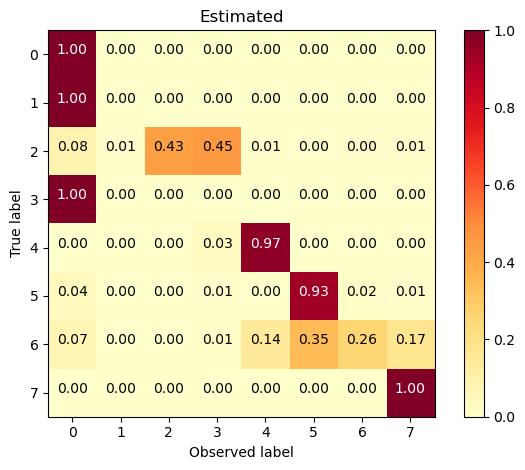

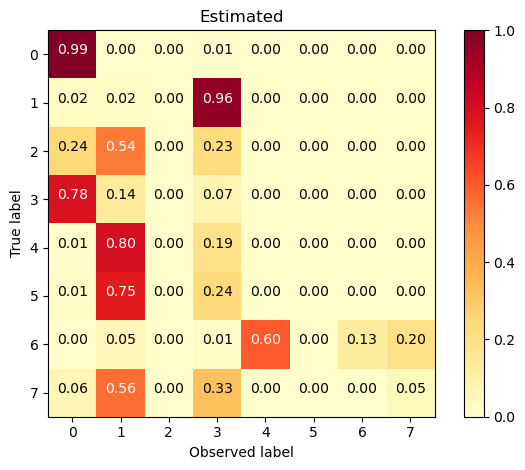

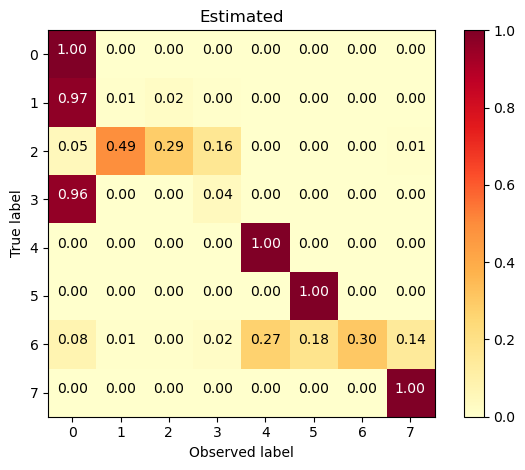

In [22]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

#### With priors= "laplace"
smooth confusion matrices

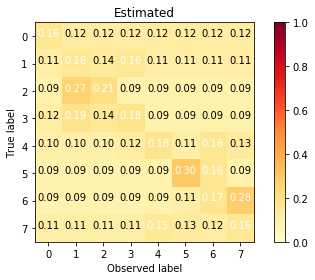

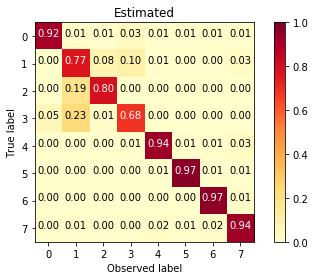

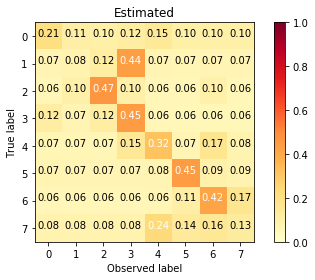

In [52]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

## CMM
Groups over global scenario

In [23]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
Total params: 66696 (260.53 KB)
Trainable params: 66696 (260.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from codeE.methods import ModelInf_EM_CMM as  CMM
CMM_model = CMM(M=M_seted) 
#CMM_model = CMM(M=M_seted, init_Z='model', n_init_Z=5, priors=0) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMM_model.set_model(aux_model, **args)

# if you want you can initialize step E forcing some method
#CMM_model.init_E(r_obs, method="hardmv")
#CMM_model.get_qestimation()

2024-01-14 20:12:46.971616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 20:12:46.972410: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
#logL_hists,i_r = CMM_model.multiples_run(20,Xstd_train,r_obs,
#                                               max_iter=EPOCHS_BASE,tolerance=TOL)

CMM_model.fit(Xstd_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step:

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


4/4 [==============================] - 0s 2ms/step
 done //  (in 0.53 sec)	logL: -3445.585	
Iter 2/50
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -2970.361	Tol1: 0.13792	Tol2: 1.61529	Tol3: 0.23831	
Iter 3/50
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.16 sec)	logL: -3155.584	Tol1: 0.06236	Tol2: 0.65779	Tol3: 0.14334	
Iter 4/50
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.16 sec)	logL: -3464.708	Tol1: 0.09796	Tol2: 0.84006	Tol3: 0.13224	
Iter 5/50
4/4 [==============================] - 0s 4ms/step
 done //  (in 0.14 sec)	logL: -3505.772	Tol1: 0.01185	Tol2: 2.37895	Tol3: 0.09173	
Iter 6/50
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.15 sec)	logL: -3636.131	Tol1: 0.03718	Tol2: 6.13885	Tol3: 0.05573	
Iter 7/50
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.18 sec)	logL: -3780.059	Tol1: 0.03958	Tol2: 1.25743	Tol3: 0.04878	
Iter 8/50
4/4 [=============================

/home/panshop/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


4/4 [==============================] - 0s 2ms/step
 done //  (in 0.52 sec)	logL: -3451.023	
Iter 2/50
4/4 [==============================] - 0s 4ms/step
 done //  (in 0.14 sec)	logL: -3018.006	Tol1: 0.12547	Tol2: 1.82032	Tol3: 0.18603	
Iter 3/50
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.14 sec)	logL: -3395.514	Tol1: 0.12509	Tol2: 0.65192	Tol3: 0.18137	
Iter 4/50
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.14 sec)	logL: -3989.673	Tol1: 0.17498	Tol2: 0.69828	Tol3: 0.12782	
Iter 5/50
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.16 sec)	logL: -4329.324	Tol1: 0.08513	Tol2: 0.80862	Tol3: 0.46828	
Iter 6/50
4/4 [==============================] - 0s 2ms/step
 done //  (in 0.19 sec)	logL: -4340.535	Tol1: 0.00259	Tol2: 96.82035	Tol3: 0.27033	
Iter 7/50
4/4 [==============================] - 0s 3ms/step
 done //  (in 0.16 sec)	logL: -4425.862	Tol1: 0.01966	Tol2: 0.33437	Tol3: 0.10976	
Iter 8/50
4/4 [============================

([array([-3445.5848, -2970.3611, -3155.5836, -3464.7082, -3505.772 ,
         -3636.1311, -3780.0589, -3782.5842, -3770.1326, -3761.9955,
         -3755.0831, -3754.3886]),
  array([-3451.0229, -3018.006 , -3395.5136, -3989.6729, -4329.324 ,
         -4340.5352, -4425.8623, -4585.0345, -4780.929 , -5032.371 ,
         -5252.5996, -5221.2053, -5221.1949, -5221.1949])],
 0)

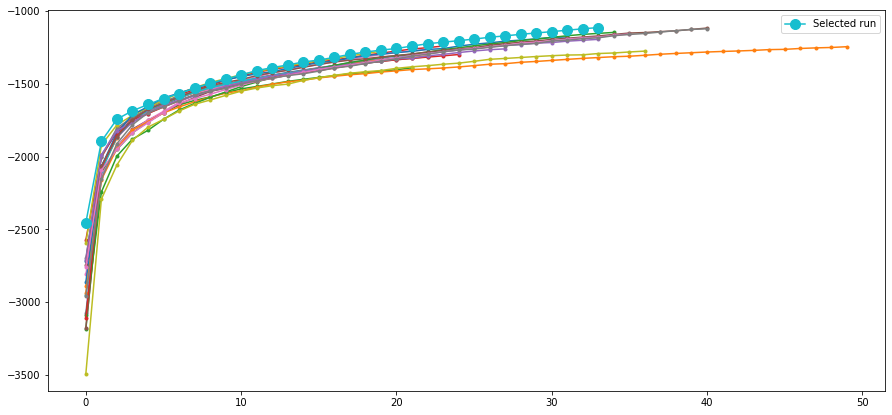

In [24]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [26]:
cmm_fx = CMM_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmm_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmm_fx, Xstd_test, Z_test))

32/32 [==============================] - 0s 1ms/step
Train accuracy of model = 0.244
38/38 [==============================] - 0s 1ms/step
Test accuracy of model = 0.25925925925925924


### Groups found

In [27]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.0645 0.9302 0.0053]


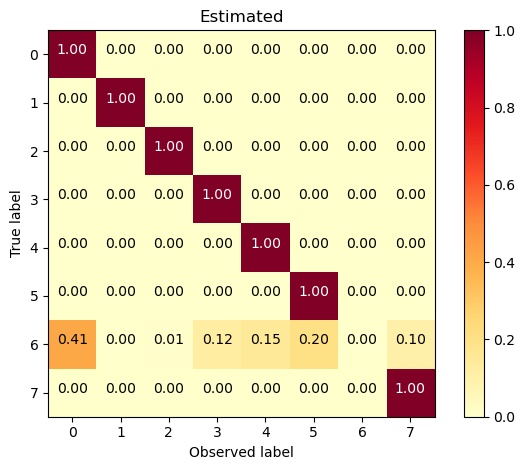

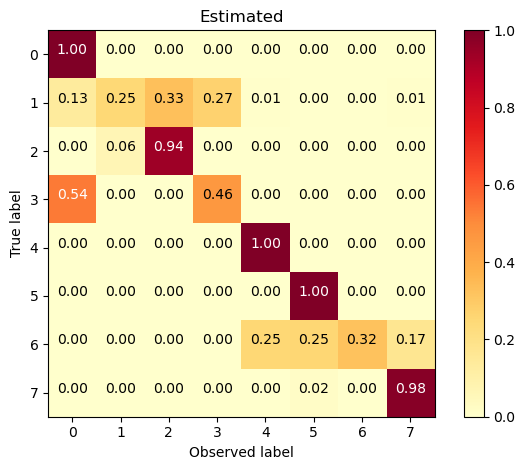

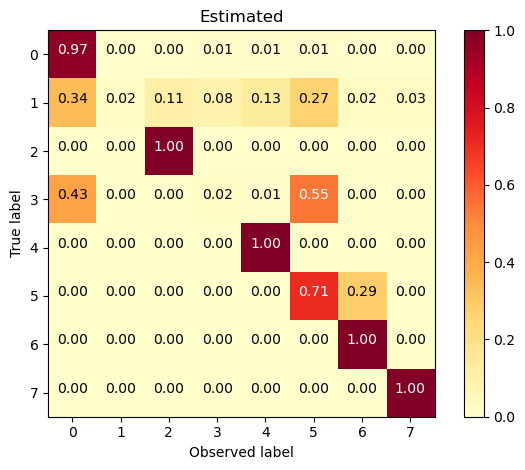

In [28]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

#### With priors= "laplace"
smooth confusion matrices

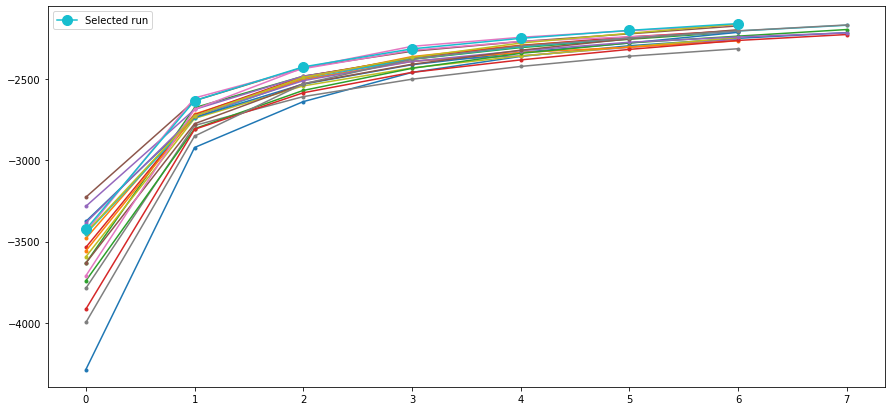

In [17]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [40]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.9987 0.0011 0.0002]


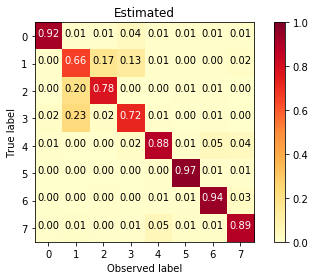

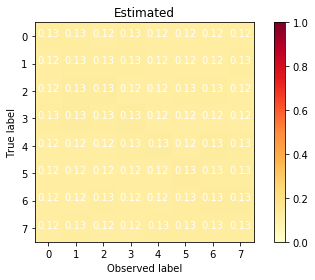

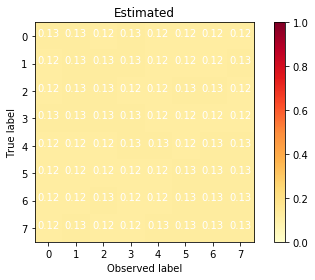

In [41]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

## Global Behavior - Label Noise
As CMM with *M=1*

In [21]:
aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [22]:
from codeE.methods import ModelInf_EM_G as G_Noise
GNoise_model = G_Noise() 
#GNoise_model = G_Noise(init_Z='model', n_init_Z=5, priors=0) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
GNoise_model.set_model(aux_model, **args)

# if you want you can initialize step E forcing some method
#GNoise_model.init_E(r_obs, method="hardmv")
#GNoise_model.get_qestimation()
logL_hists,i_r = GNoise_model.fit(Xstd_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Pre-train network sequential_1 on 5 epochs... Done!
Beta:  (8, 8)
Q estimate:  (1000, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1846.314	
Iter 2/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1649.503	Tol1: 0.10660	Tol2: 0.60448	
Iter 3/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1614.870	Tol1: 0.02100	Tol2: 0.36085	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1587.314	Tol1: 0.01706	Tol2: 0.21759	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1568.303	Tol1: 0.01198	Tol2: 0.08735	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1551.367	Tol1: 0.01080	Tol2: 0.04846	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1535.877	Tol1: 0.00998	Tol2: 0.04132	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1522.297	Tol1: 0.00884	Tol2: 0.03095	
Iter 9/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1510.065	Tol1: 0.00803	Tol2: 0.02412	
Finishe

M step: done,  E step: done //  (in 0.03 sec)	logL: -1492.432	Tol1: 0.00886	Tol2: 0.04023	
Iter 11/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1482.933	Tol1: 0.00636	Tol2: 0.03661	
Iter 12/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1476.261	Tol1: 0.00450	Tol2: 0.03133	
Iter 13/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1467.858	Tol1: 0.00569	Tol2: 0.03364	
Iter 14/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1459.852	Tol1: 0.00545	Tol2: 0.03592	
Iter 15/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1454.073	Tol1: 0.00396	Tol2: 0.03282	
Iter 16/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1446.293	Tol1: 0.00535	Tol2: 0.03117	
Iter 17/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1440.397	Tol1: 0.00408	Tol2: 0.02984	
Finished training!
Initializing new EM...
Pre-train network sequential_1 on 5 epochs... Done!
Beta:  (8, 8)
Q estimate:  (1000, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1

M step: done,  E step: done //  (in 0.03 sec)	logL: -1856.054	
Iter 2/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1673.439	Tol1: 0.09839	Tol2: 0.59814	
Iter 3/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1639.346	Tol1: 0.02037	Tol2: 0.36656	
Iter 4/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1614.240	Tol1: 0.01531	Tol2: 0.19734	
Iter 5/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1591.731	Tol1: 0.01394	Tol2: 0.11789	
Iter 6/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1572.906	Tol1: 0.01183	Tol2: 0.07320	
Iter 7/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1557.484	Tol1: 0.00981	Tol2: 0.06245	
Iter 8/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1543.434	Tol1: 0.00902	Tol2: 0.05588	
Iter 9/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1531.419	Tol1: 0.00778	Tol2: 0.04737	
Iter 10/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1519.551	Tol1: 0.00775	Tol2: 0.04603	
Iter 11/50
M step: done,  E

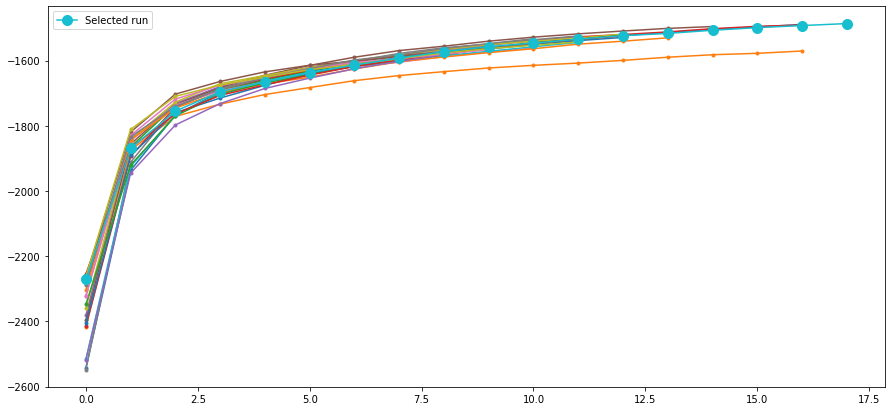

In [53]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [54]:
G_fx = GNoise_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(G_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(G_fx, Xstd_test, Z_test))

Train accuracy of model = 0.871
Test accuracy of model = 0.8720538720538721


## Confusion Matrices Visualization

In [42]:
from codeE.utils import generate_confusionM
from codeE.utils import plot_confusion_matrix, compare_conf_ma, compare_set_conf_ma
from codeE.evaluation import Individual_D, D_JS, D_NormF

> ### Global scenario

#### MV

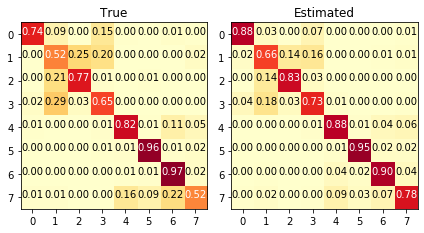

Global D (based on Jensen Shannon) = 0.024224901133546403
Global D (based on normalized Frobenius) = 0.05655808001756668


In [56]:
### SOFT
prob_Yz = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotations
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

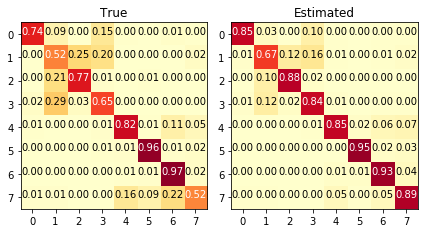

Global D (based on Jensen Shannon) = 0.03469416227325334
Global D (based on normalized Frobenius) = 0.07360906898975372


In [57]:
### HARD
prob_Yz = generate_confusionM(mv_hard, r_obs) 
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### CMM

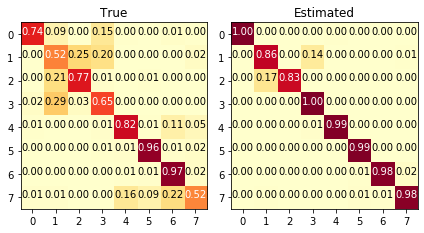

Global D (based on Jensen Shannon) = 0.10981982489480833
Global D (based on normalized Frobenius) = 0.11346241964131841


In [61]:
prob_Yz = CMM_model.get_global_confusionM()

compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### Global - Label Noise (without predictive model)

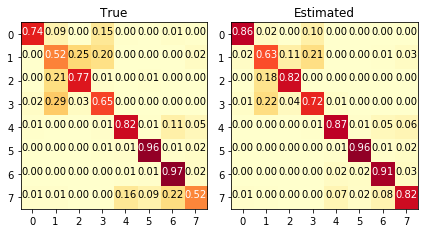

Global D (based on Jensen Shannon) = 0.023675663789100344
Global D (based on normalized Frobenius) = 0.05575958639383316


In [43]:
prob_Yz = LabG_Noise_model.get_global_confusionM()
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### Global - Label Noise (with predictive model)

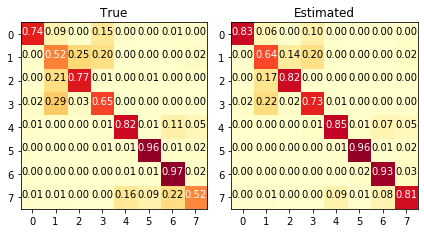

Global D (based on Jensen Shannon) = 0.019286933918358982
Global D (based on normalized Frobenius) = 0.052080187946558


In [60]:
prob_Yz = GNoise_model.get_global_confusionM()
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

> ###  Individual scenario

#### DS

Plot 5 random matrices from the set


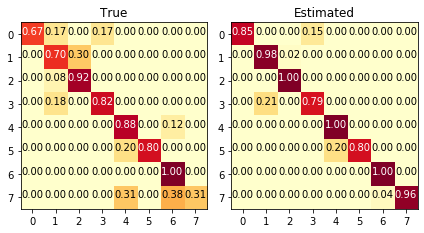

D (based on Jensen Shannon) = 0.08836828690006351
D (based on normalized Frobenius) = 0.11857955157756805


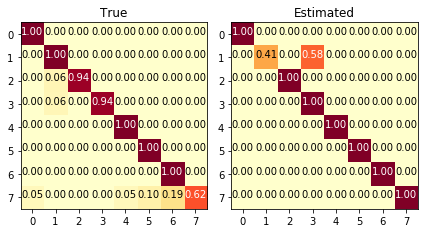

D (based on Jensen Shannon) = 0.08307941192723635
D (based on normalized Frobenius) = 0.11814256012439728


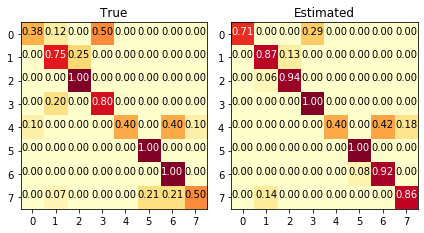

D (based on Jensen Shannon) = 0.07921121576523493
D (based on normalized Frobenius) = 0.09206711500883102


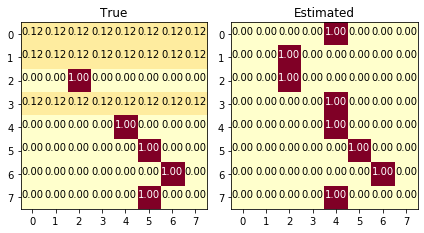

D (based on Jensen Shannon) = 0.39383958254522833
D (based on normalized Frobenius) = 0.2688226103782654


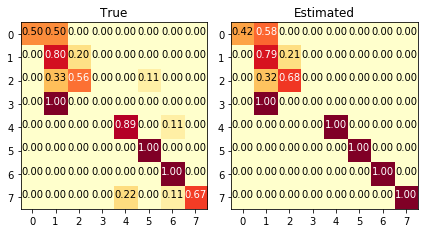

D (based on Jensen Shannon) = 0.03921826801889847
D (based on normalized Frobenius) = 0.061064206063747406


In [62]:
prob_Yzt = DS_model.get_ann_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [63]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.18280751182126098
Individual D_NormF =  0.14954937672463514


#### Raykar

Plot 5 random matrices from the set


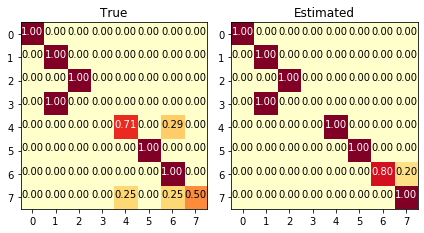

D (based on Jensen Shannon) = 0.07236461330667572
D (based on normalized Frobenius) = 0.09827770292758942


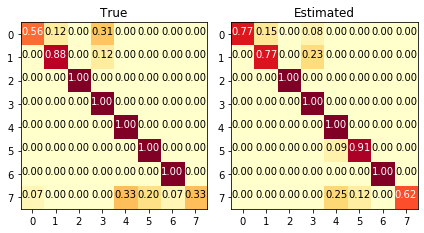

D (based on Jensen Shannon) = 0.02949044021043462
D (based on normalized Frobenius) = 0.06131871044635773


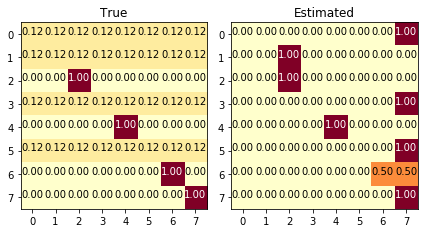

D (based on Jensen Shannon) = 0.3973644099703243
D (based on normalized Frobenius) = 0.25


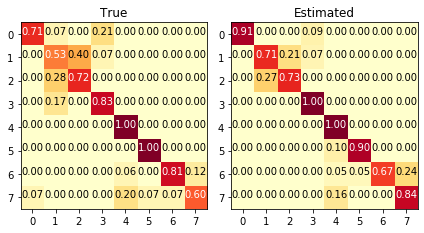

D (based on Jensen Shannon) = 0.04897125366450884
D (based on normalized Frobenius) = 0.06948746740818024


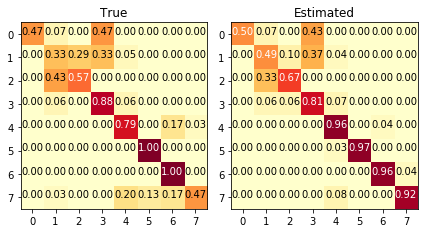

D (based on Jensen Shannon) = 0.053370913838881213
D (based on normalized Frobenius) = 0.08089034259319305


In [64]:
prob_Yzt = R_model.get_ann_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [65]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.1690653682297128
Individual D_NormF =  0.14124351278957675


#### C-MoA

Plot 5 random matrices from the set


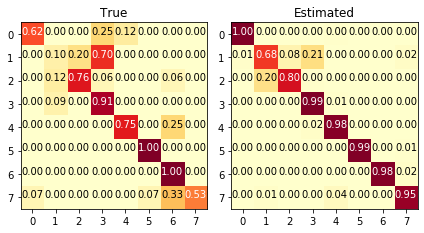

D (based on Jensen Shannon) = 0.13333277132973523
D (based on normalized Frobenius) = 0.13932441008873864


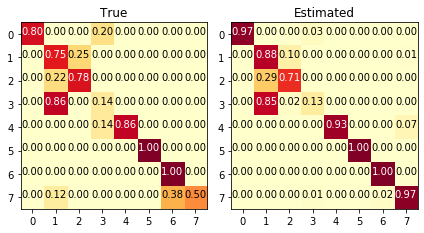

D (based on Jensen Shannon) = 0.05937812962771182
D (based on normalized Frobenius) = 0.08855696971064486


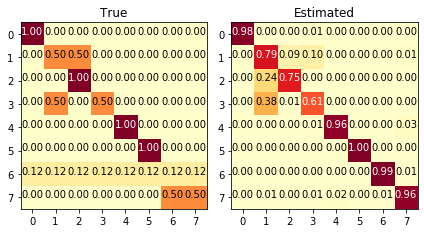

D (based on Jensen Shannon) = 0.17235314725099216
D (based on normalized Frobenius) = 0.16454138213986108


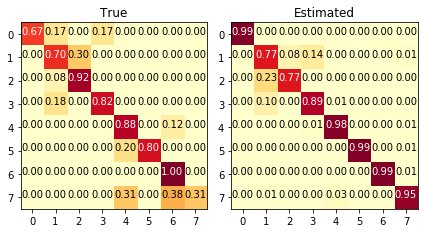

D (based on Jensen Shannon) = 0.11893984905323077
D (based on normalized Frobenius) = 0.12674637831775135


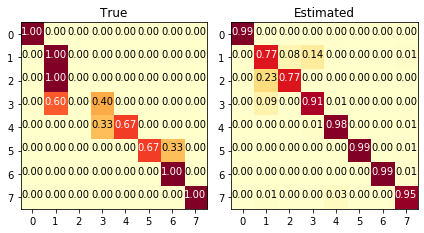

D (based on Jensen Shannon) = 0.1653198365724449
D (based on normalized Frobenius) = 0.18607829604174153


In [111]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Yzt = CMOA_model.get_ann_confusionM(A) # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [112]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.21964091630656604
Individual D_NormF =  0.17464322413187133


#### Reliability

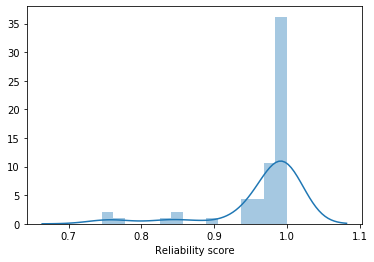

Mean score = 0.9664877170280212
Maximum score = 1.0
Minimum score = 0.7452888488769531


In [45]:
sns.distplot(LogReg_crowds.get_ann_rel().flatten())
plt.xlabel("Reliability score")
plt.show()

print("Mean score =", LogReg_crowds.get_ann_rel().mean())
print("Maximum score =", LogReg_crowds.get_ann_rel().max())
print("Minimum score =", LogReg_crowds.get_ann_rel().min())

> ### Extras

#### CMM could estimates individual matrices 

Plot 5 random matrices from the set


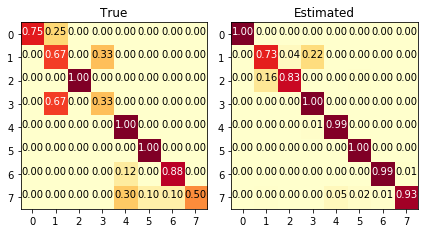

D (based on Jensen Shannon) = 0.12207750657429887
D (based on normalized Frobenius) = 0.1466240418197508


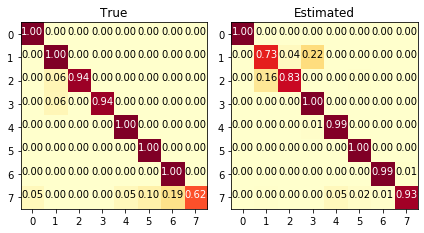

D (based on Jensen Shannon) = 0.04512257977448255
D (based on normalized Frobenius) = 0.06707006407693246


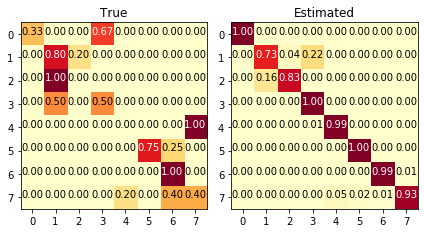

D (based on Jensen Shannon) = 0.3796481687316231
D (based on normalized Frobenius) = 0.2911500015566223


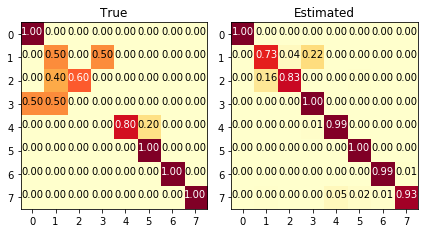

D (based on Jensen Shannon) = 0.16080972917847108
D (based on normalized Frobenius) = 0.16898593543600918


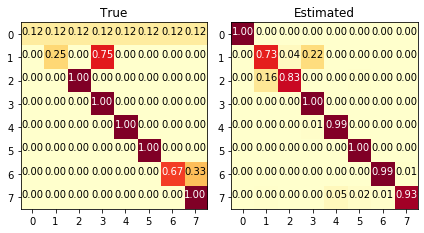

D (based on Jensen Shannon) = 0.15305618256118697
D (based on normalized Frobenius) = 0.1607585246217449


In [113]:
prob_Yzt = []
for t in range(y_obs.shape[1]):
    conf = CMM_model.get_ann_confusionM(Xstd_train, y_obs[:,t])
    
    prob_Yzt.append(conf)
prob_Yzt = np.asarray(prob_Yzt)

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [114]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.25795908990516725
Individual D_NormF =  0.19971322223225732


#### C-MoA could estimates global matrices 

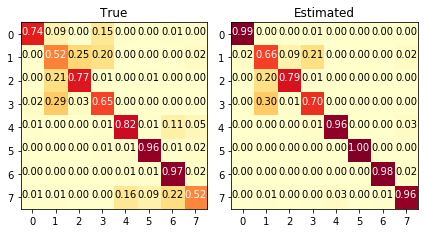

In [115]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Gt = CMOA_model.get_predictions_g(A)

prob_Yz = CMOA_model.get_global_confusionM(prob_Gt)

compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

In [116]:
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.06240330116293328
Global D (based on normalized Frobenius) = 0.0821379850510367


### The behaviors of the groups found by CMM and CMOA

In [23]:
from codeE.evaluation import I_sim, R_score, H_conf, S_score, S_bias

**For CMM**
Group  1


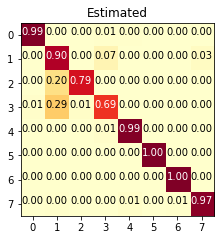

Expertise Identity (I_sim) = 0.9540979828771412
Expertise Diagonal (R_score) = 0.9160896116831443
Randomness (H_conf) = 0.11552080874812563
Spammer score (S_score) = 0.9041024133521649
Bias for class index 1 with score = 0.007012
-------------------------------------------------
Group  2


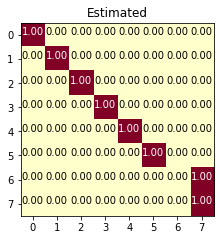

Expertise Identity (I_sim) = 0.8750044855008429
Expertise Diagonal (R_score) = 0.8749989728907885
Randomness (H_conf) = 1.714886540678934e-05
Spammer score (S_score) = 0.8571416833037584
Bias for class index 7 with score = 0.083329
-------------------------------------------------
Group  3


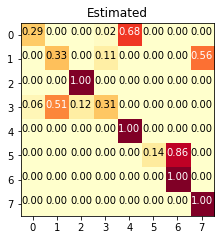

Expertise Identity (I_sim) = 0.7314065052352612
Expertise Diagonal (R_score) = 0.6333088773048708
Randomness (H_conf) = 0.19119125100340648
Spammer score (S_score) = 0.5809244312055666
Bias for class index 6 with score = 0.102594
-------------------------------------------------


In [27]:
print("**For CMM**")

B = CMM_model.get_confusionM()

for i, b in enumerate(B):
    print("Group ",(i+1))
    compare_conf_ma(b, text=True)

    print("Expertise Identity (I_sim) =", I_sim(b))
    print("Expertise Diagonal (R_score) =", R_score(b))
    print("Randomness (H_conf) =", H_conf(b))
    print("Spammer score (S_score) =", S_score(b))
    print("Bias for class index %d with score = %f"%(S_bias(b)))
    print("-------------------------------------------------")

**For C-MoA**
Group  1


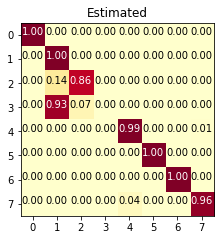

Expertise Identity (I_sim) = 0.8632872289684169
Expertise Diagonal (R_score) = 0.8521544584971488
Randomness (H_conf) = 0.05113411915677229
Spammer score (S_score) = 0.8310336668538842
Bias for class index 1 with score = 0.086416
-------------------------------------------------
Group  2


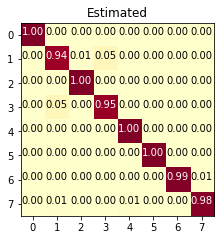

Expertise Identity (I_sim) = 0.9905997651136185
Expertise Diagonal (R_score) = 0.9815206040182208
Randomness (H_conf) = 0.03926926427596057
Spammer score (S_score) = 0.9788806903065381
Bias for class index 4 with score = 0.000009
-------------------------------------------------
Group  3


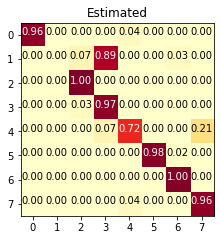

Expertise Identity (I_sim) = 0.8469872752820234
Expertise Diagonal (R_score) = 0.8233608767601719
Randomness (H_conf) = 0.10381542823266675
Spammer score (S_score) = 0.7981267162973391
Bias for class index 3 with score = 0.083390
-------------------------------------------------


In [28]:
print("**For C-MoA**")

B = CMOA_model.get_confusionM()

for i, b in enumerate(B):
    print("Group ",(i+1))
    compare_conf_ma(b, text=True)

    print("Expertise Identity (I_sim) =", I_sim(b))
    print("Expertise Diagonal (R_score) =", R_score(b))
    print("Randomness (H_conf) =", H_conf(b))
    print("Spammer score (S_score) =", S_score(b))
    print("Bias for class index %d with score = %f"%(S_bias(b)))
    print("-------------------------------------------------")